# Photonic Sentry Data Analysis

In [1]:
%matplotlib inline

## Import Libraries  
If using colab, mount Google Drive.

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Set PATH_TO_DATA to the absolute path of your folder containing all data
# Set PATH_TO_GROUND_TRUTH to the absolute path of the csv file containing ground truth information
PATH_TO_DATA = '/content/gdrive/My Drive/pfmd_data/data'
PATH_TO_GROUND_TRUTH = '/content/gdrive/My Drive/pfmd_data/ground_truth_values.csv'

### Load data  
Check that the path leads to the folder containing desired data.

In [4]:
def preprocess(track):
  # Filter by size
  is_large = track['size_mm2'] > 35
  but_not_too_large = track['size_mm2'] < 45

  out = track[is_large & but_not_too_large].copy()
  return track

In [5]:
# Using least squares
def normalize(track, zero=False):
    curr = track.copy()
    constant = np.ones(len(curr))
    x_vals = track['x_cm']
    y_vals = track['y_cm']
    A = np.vstack((x_vals, y_vals, constant)).T
    b = track['z_cm']
    theta = np.linalg.inv(A.T@A)@A.T@b
    sorted_x = curr['x_cm'].sort_values()
    sorted_y = curr['y_cm'].sort_values()
    fit_line = theta[0]*sorted_x + theta[1]*sorted_y
    curr['z_cm'] -= fit_line
    if zero:
      curr['z_cm'] -= theta[2]
    return curr, theta

In [6]:
# Pass in a list of file names if you want to omit certain data in your directory
def load_data(without):
  data = {}
  ndata = {}
  zndata = {}
  theta_data = []
  ground_truth = pd.read_csv(PATH_TO_GROUND_TRUTH, index_col=0)

  for folder in os.listdir(PATH_TO_DATA):
    if folder not in without:
      print('Reading in data from ' + folder)
      for file_name in os.listdir(PATH_TO_DATA + '/' + folder):
        if file_name in ground_truth.index:                                   # and file_name not in without:
          # Read in the track data
          track = pd.read_csv(PATH_TO_DATA + '/' + folder + '/' + file_name)
          name = ground_truth.loc[file_name, 'name']
          # Get the ground truth for the track
          truth = ground_truth.loc[file_name, 'ground_truth']
          # Find the ground truth axis
          axis = name[0] + '_cm'
          # Preprocess
          # track = preprocess(track)
          ntrack, thetas = normalize(track)
          zntrack, thetas = normalize(track, True)
          # Create a column of error from ground truth
          track['truth_err'] = track[axis] - (truth*100)
          ntrack['truth_err'] = ntrack[axis] - truth*100
          zntrack['truth_err'] = zntrack[axis]
          # Store the track into the dictionary data
          data[name] = track
          ndata[name] = ntrack
          zndata[name] = zntrack
          # Update the theta data
          curr = {'track':name, 
                  'configuration': folder, 
                  'constant_weight': thetas[2], 
                  'x_weight': thetas[0], 
                  'y_weight':thetas[1]}
          theta_data.append(curr)
  theta_data = pd.DataFrame(theta_data)
  return data, ndata, zndata, theta_data

data, ndata, zndata, theta_data = load_data(['x_center', 'x_right'])

Reading in data from z_up
Reading in data from z_upagain
Reading in data from z_down
Reading in data from z_far
Reading in data from z_neardown
Reading in data from z_right
Reading in data from z_nearup
Reading in data from z_00
Reading in data from z_left
Reading in data from z_up_flipped


In [7]:
def heat_map(data, n=10, val='truth_err'):
  mean_df = pd.concat([data[name] for name in data])
  # NOTE that all data at (x, y) are taken into account, including those at different z values.
  # Create columns labelling the bin each row falls under
  x_bins = pd.cut(mean_df['x_cm'], bins=n, precision=1)
  y_bins = pd.cut(mean_df['y_cm'], bins=n, precision=1)
  mean_df['x_bin'] = x_bins
  mean_df['y_bin'] = y_bins
  # Group rows of the same bin together 
  bins = mean_df.groupby(['y_bin', 'x_bin'])[val].mean()
  counts = mean_df.groupby(['y_bin', 'x_bin'])[val].count()
  # Create numpy array for plotting
  err_matrix = bins.to_numpy()
  err_matrix = np.flipud(err_matrix.reshape((n, n)))
  counts_matrix = counts.to_numpy()
  counts_matrix = np.flipud(counts_matrix.reshape((n, n)))
  # Filter and sort the bins to return as labels
  x_bins = x_bins.unique()
  x_bins = sorted(x_bins, reverse=False)
  y_bins = y_bins.unique()
  y_bins = sorted(y_bins, reverse=True)
  return err_matrix, x_bins, y_bins, counts_matrix/100

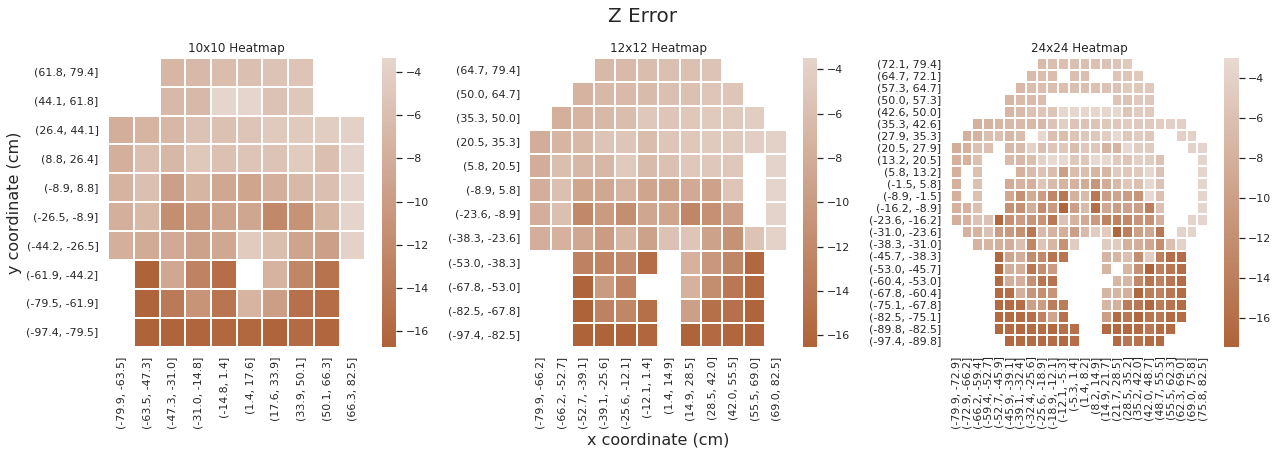

In [8]:
dim = [10, 12, 24]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, n in enumerate(dim):
    ax = axs[i]
    mat, x_bins, y_bins, counts = heat_map(data, n, 'truth_err')
    # Set pallete
    colors = sns.diverging_palette(30, 300, as_cmap=True)
    # Plot
    hmap = sns.heatmap(data=mat,
                ax=ax, 
                center=0,
                xticklabels=x_bins,
                yticklabels=y_bins,
                linewidth=1,
                # annot=counts,   # Displays counts on cells (in 100s)
                cmap=colors)
    # Set subplot titles
    ax.set_title(str(n) + 'x' + str(n) + ' Heatmap')
    # Set background color for empty bins
    hmap.set_facecolor('w')

# Set titles
axs[1].set_xlabel('x coordinate (cm)', fontsize=16)
axs[0].set_ylabel('y coordinate (cm)', fontsize=16)
fig.suptitle('Z Error', y=1.05, fontsize=20)
fig.tight_layout()

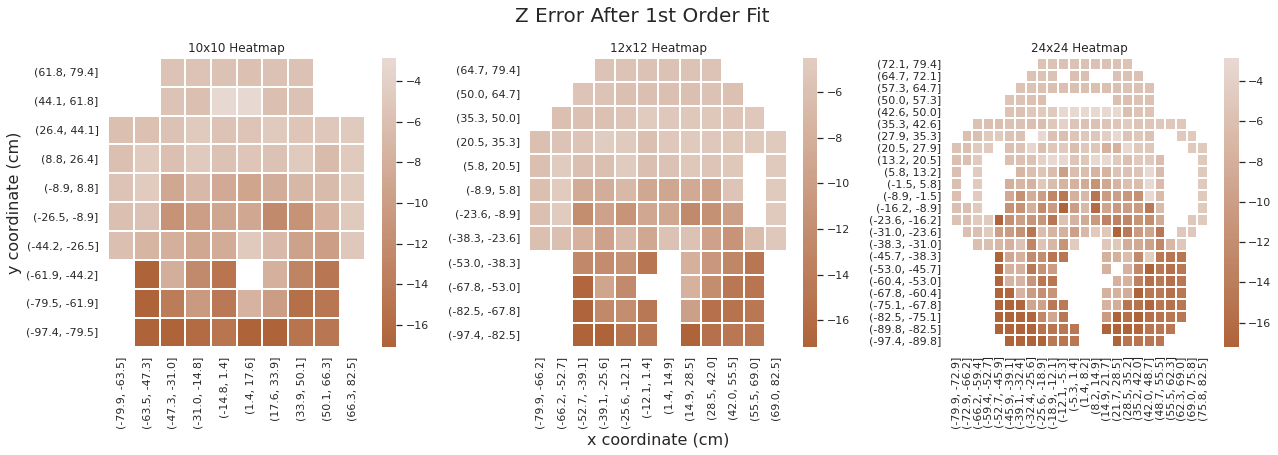

In [9]:
dim = [10, 12, 24]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, n in enumerate(dim):
    ax = axs[i]
    mat, x_bins, y_bins, counts = heat_map(ndata, n, 'truth_err')
    # Set pallete
    colors = sns.diverging_palette(30, 300, as_cmap=True)
    # Plot
    hmap = sns.heatmap(data=mat,
                ax=ax, 
                center=0,
                xticklabels=x_bins,
                yticklabels=y_bins,
                linewidth=1,
                # annot=counts,   # Displays counts on cells (in 100s)
                cmap=colors)
    # Set subplot titles
    ax.set_title(str(n) + 'x' + str(n) + ' Heatmap')
    # Set background color for empty bins
    hmap.set_facecolor('w')

# Set titles
axs[1].set_xlabel('x coordinate (cm)', fontsize=16)
axs[0].set_ylabel('y coordinate (cm)', fontsize=16)
fig.suptitle('Z Error After 1st Order Fit', y=1.05, fontsize=20)
fig.tight_layout()

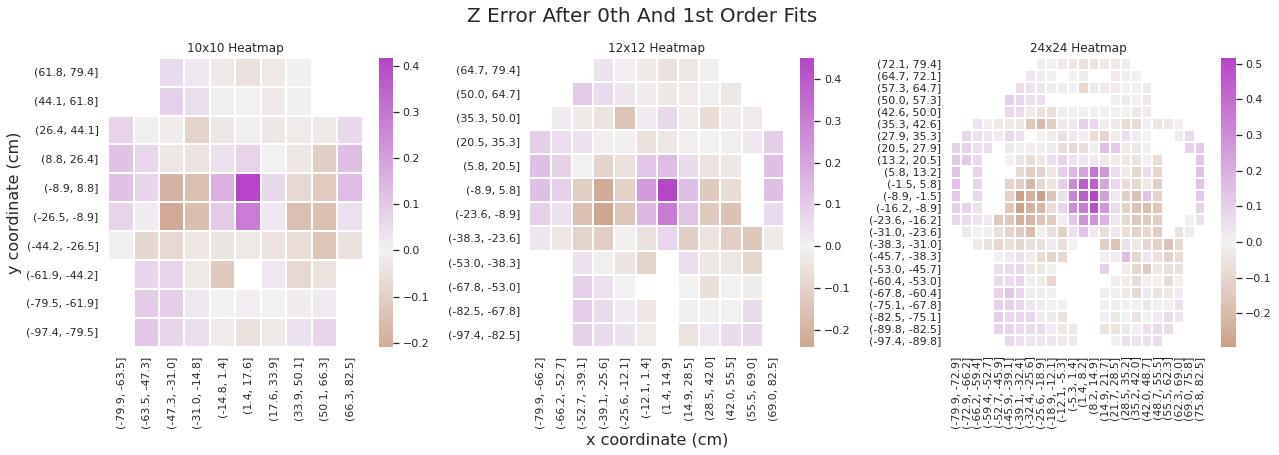

In [10]:
dim = [10, 12, 24]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, n in enumerate(dim):
    ax = axs[i]
    mat, x_bins, y_bins, counts = heat_map(zndata, n, 'truth_err')
    # Set pallete
    colors = sns.diverging_palette(30, 300, as_cmap=True)
    # Plot
    hmap = sns.heatmap(data=mat,
                ax=ax, 
                center=0,
                xticklabels=x_bins,
                yticklabels=y_bins,
                linewidth=1,
                # annot=counts,   # Displays counts on cells (in 100s)
                cmap=colors)  
    # Set subplot titles
    ax.set_title(str(n) + 'x' + str(n) + ' Heatmap')
    # Set background color for empty bins
    hmap.set_facecolor('w')

# Set titles
axs[1].set_xlabel('x coordinate (cm)', fontsize=16)
axs[0].set_ylabel('y coordinate (cm)', fontsize=16)
fig.suptitle('Z Error After 0th And 1st Order Fits', y=1.05, fontsize=20)
fig.tight_layout()

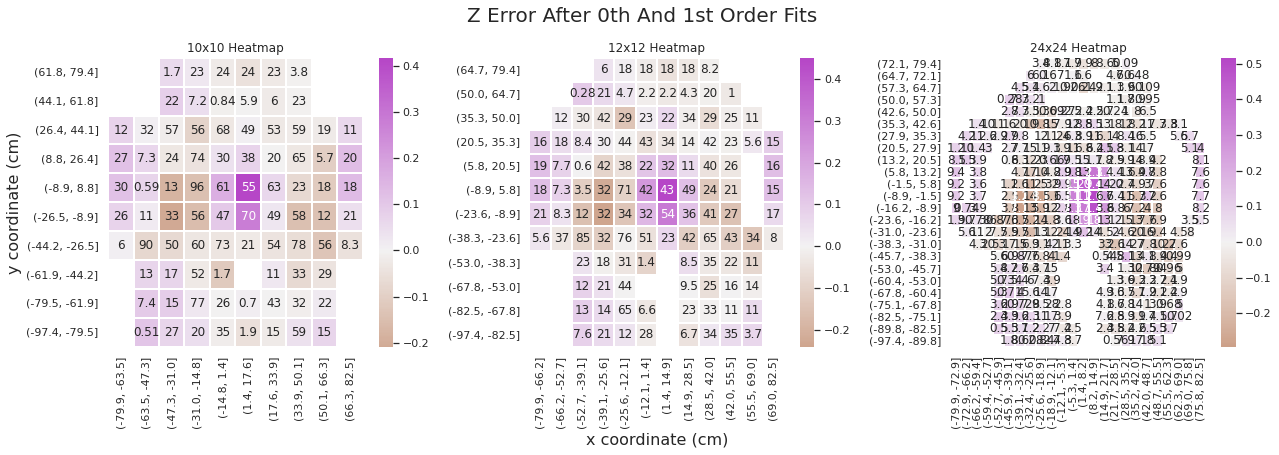

In [11]:
dim = [10, 12, 24]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, n in enumerate(dim):
    ax = axs[i]
    mat, x_bins, y_bins, counts = heat_map(zndata, n, 'truth_err')
    # Set pallete
    colors = sns.diverging_palette(30, 300, as_cmap=True)
    # Plot
    hmap = sns.heatmap(data=mat,
                ax=ax, 
                center=0,
                xticklabels=x_bins,
                yticklabels=y_bins,
                linewidth=1,
                annot=counts,   # Displays counts on cells (in 100s)
                cmap=colors)  
    # Set subplot titles
    ax.set_title(str(n) + 'x' + str(n) + ' Heatmap')
    # Set background color for empty bins
    hmap.set_facecolor('w')

# Set titles
axs[1].set_xlabel('x coordinate (cm)', fontsize=16)
axs[0].set_ylabel('y coordinate (cm)', fontsize=16)
fig.suptitle('Z Error After 0th And 1st Order Fits', y=1.05, fontsize=20)
fig.tight_layout()

In [12]:
# Run this to check if any tracks might have points of unusually high error
for path in data:
  if max(abs(zndata[path]['truth_err'])) > 10:
    print(path)

Text(0.5, 1.0, 'Comparing Original and First Order Models')

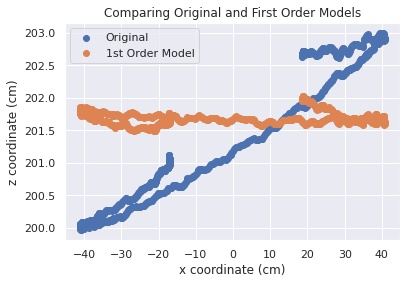

In [13]:
example = data['z_down_10']
nexample = ndata['z_down_10']
znexample = zndata['z_down_10']
plt.scatter(x=example['x_cm'], y=example['z_cm'], label='Original')
plt.scatter(x=nexample['x_cm'], y=nexample['z_cm'], label='1st Order Model')
plt.legend()
plt.xlabel('x coordinate (cm)')
plt.ylabel('z coordinate (cm)')
plt.title('Comparing Original and First Order Models')

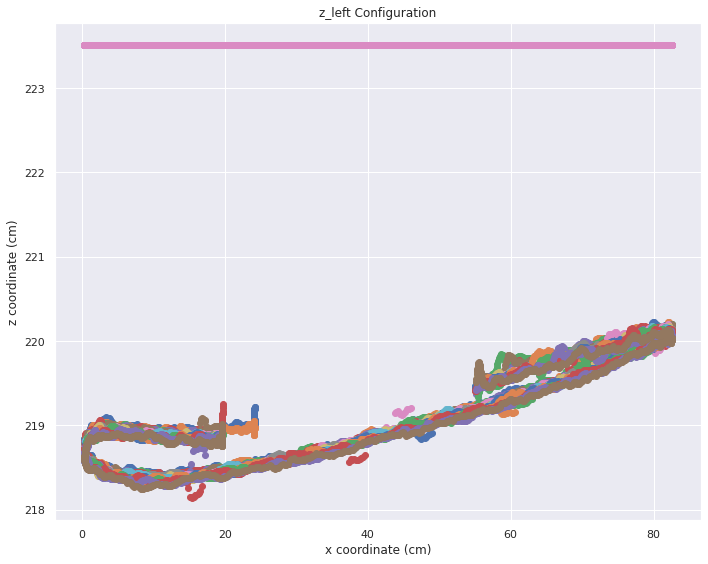

In [14]:
fig, ax = plt.subplots(1, figsize=(10, 8))
for trial in range(1, 17):
  track = 'z_left_' + str(trial)
  plt.scatter(x=data[track]['x_cm'], y=data[track]['z_cm'], label=trial)
plt.scatter(x=data[track]['x_cm'], y=[223.5075]*len(data[track]), label='z measured')
plt.xlabel('x coordinate (cm)')
plt.ylabel('z coordinate (cm)')
plt.title('z_left Configuration')
plt.tight_layout()

In [15]:
columns_of_interest = ['constant_weight', 'x_weight', 'y_weight']
for column in columns_of_interest:
  curr_mean = theta_data.groupby('configuration')[column].mean()
  curr_std = theta_data.groupby('configuration')[column].std()
  for row in curr_mean.index:
    print(row + ':')
    print('   The {weight} has a mean of {mean}'.format(weight=' '.join(column.split('_')), mean=curr_mean[row]))
    print('   The {weight} has a standard deviation of {std}'.format(weight=' '.join(column.split('_')), std=curr_std[row]))
  print('\n')   

z_00:
   The constant weight has a mean of 241.61758567319666
   The constant weight has a standard deviation of 0.1258071485638
z_down:
   The constant weight has a mean of 201.68097986550984
   The constant weight has a standard deviation of 0.022544943553375635
z_far:
   The constant weight has a mean of 314.6013275977883
   The constant weight has a standard deviation of 0.07604827510761533
z_left:
   The constant weight has a mean of 218.51504959277753
   The constant weight has a standard deviation of 0.06870055421368979
z_neardown:
   The constant weight has a mean of 133.76058472765598
   The constant weight has a standard deviation of 0.08864256217192684
z_nearup:
   The constant weight has a mean of 134.06237606238918
   The constant weight has a standard deviation of 0.04634916747834751
z_right:
   The constant weight has a mean of 203.28545269238674
   The constant weight has a standard deviation of 16.985059772139266
z_up:
   The constant weight has a mean of 236.659530485

In [16]:
# truths = [max(data[track]['z_cm'] + data[track]['truth_err']) for track in theta_data['track']]
ground_truth = pd.read_csv(PATH_TO_GROUND_TRUTH, index_col=0)
truths = []
for track in theta_data['track']:
  is_track = ground_truth['name'] == track
  truths.append(round(ground_truth[is_track]['ground_truth'][0]*100, 2).astype(str))
theta_data['truth'] = truths
# theta_data = theta_data[theta_data['']]
theta_data

,track,configuration,constant_weight,x_weight,y_weight,truth
0,z_up_1,z_up,236.664068,0.033890,0.013586,251.04
1,z_up_12,z_up,236.485418,0.022595,0.013762,251.94
2,z_up_30,z_up,236.739464,-0.009696,0.013474,251.44
3,z_up_17,z_up,236.725741,-0.010347,0.012914,251.44
4,z_up_21,z_up,236.581315,-0.010224,0.013419,251.44
...,...,...,...,...,...,...
260,z_up_flipped_3,z_up_flipped,185.987872,0.007914,-0.002531,200.28
261,z_up_flipped_1,z_up_flipped,185.980822,0.008805,-0.003431,200.28
262,z_up_flipped_2,z_up_flipped,185.975052,0.008859,-0.002701,200.28
263,z_up_flipped_5,z_up_flipped,186.033498,0.008647,-0.002660,200.28


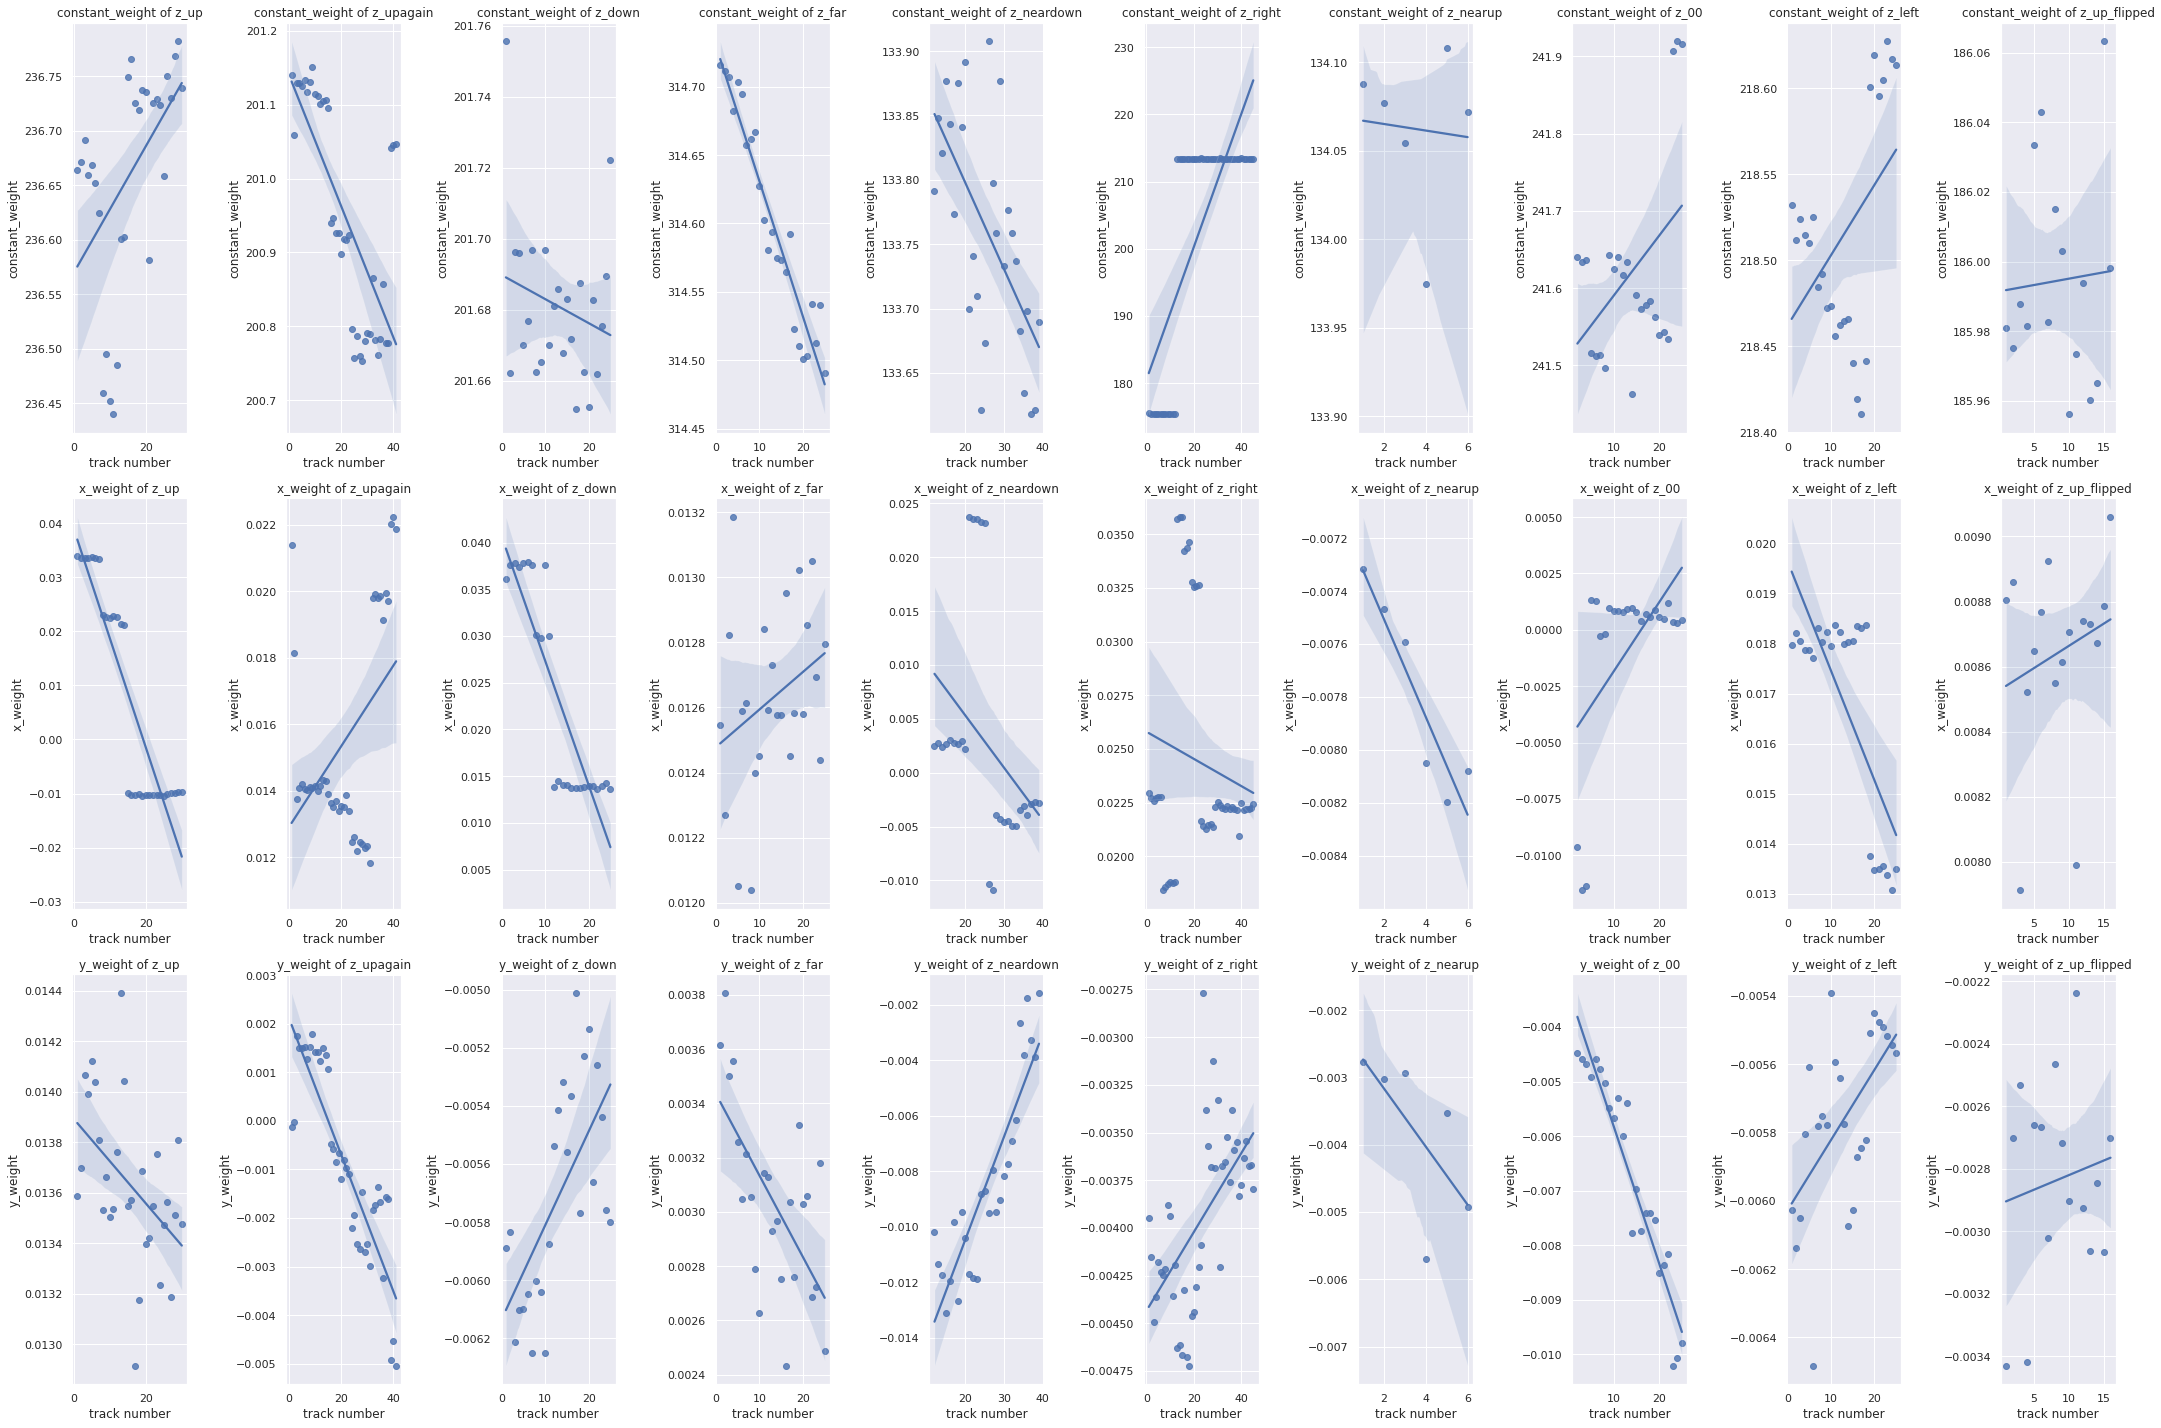

In [17]:
idxs = theta_data['configuration'].unique()
weights = ['constant_weight', 'x_weight', 'y_weight']
fig, axs = plt.subplots(len(weights), len(idxs), figsize=(30,20))

for i, weight in enumerate(weights):
  for j, idx in enumerate(idxs):
    ax = axs[i, j]
    curr_theta = theta_data[theta_data['configuration'] == idx].copy()
    curr_theta['track number'] = [int(name.split('_')[-1]) for name in curr_theta['track']]
    curr_theta = curr_theta.sort_values(by='track number')
    # ax.set_xticklabels(curr_theta['track number'], rotation=90)
    sns.regplot(x='track number',
                y=weight,
                data=curr_theta,
                scatter=True,
                # hue='truth',
                ax=ax)
    ax.set_title('{weight} of {configuration}'.format(weight=weight, configuration=idx))
fig.tight_layout()

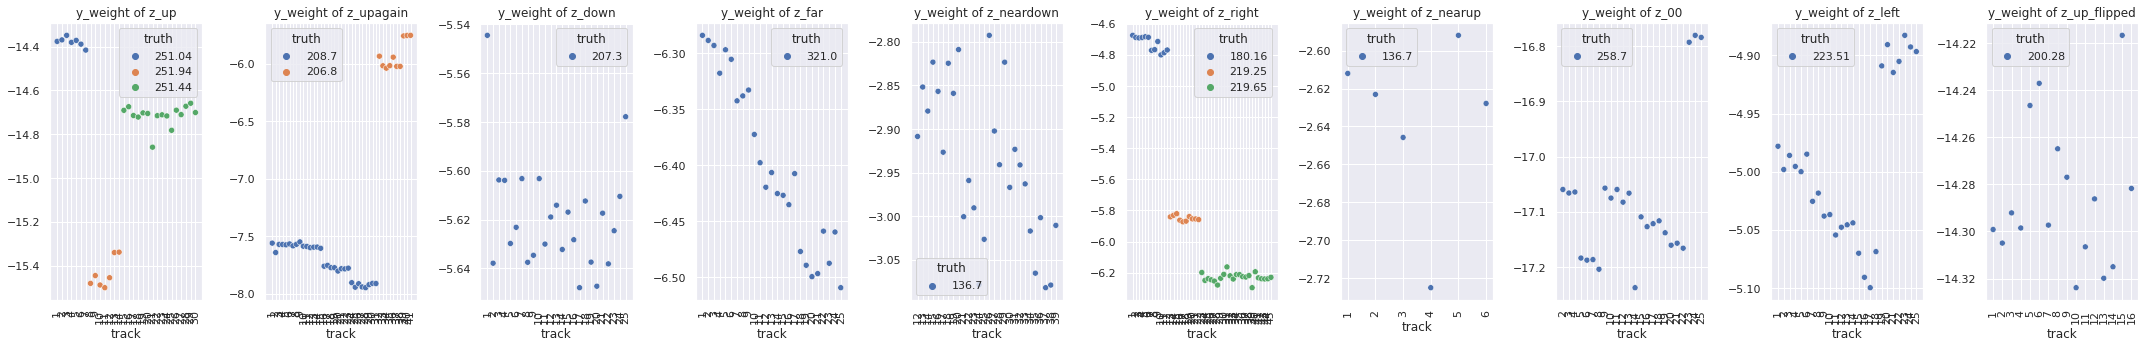

In [18]:
fig, axs = plt.subplots(1, len(idxs), figsize=(30, 5))

for j, idx in enumerate(idxs):
  ax = axs[j]
  curr_theta = theta_data[theta_data['configuration'] == idx].copy()
  curr_theta['track number'] = [int(name.split('_')[-1]) for name in curr_theta['track']]
  curr_theta = curr_theta.sort_values(by='track number')
  ax.set_xticklabels(curr_theta['track number'], rotation=90)
  sns.scatterplot(x='track',
                  y=curr_theta['constant_weight'] - curr_theta['truth'].astype(float),
                  data=curr_theta,
                  hue='truth',
                  ax=ax)
  ax.set_title('{weight} of {configuration}'.format(weight=weight, configuration=idx))
fig.tight_layout()

In [19]:
print('Displacement mean: {mean}'.format(mean=(theta_data['constant_weight'] - theta_data['truth'].astype(float)).mean()))
print('Displacement sd: {sd}'.format(sd=(theta_data['constant_weight'] - theta_data['truth'].astype(float)).std()))

Displacement mean: -8.163147834397543
Displacement sd: 4.610983727124144
